# Observed and Unobserved Confounding
**Confounders** are variables that causally influence both treatment assignment $A$ and the outcome $Y$. Failure to properly account for confounders can invalidate an otherwise pristine causal analysis. Fortunately, when all of the confounders are *known* and *observed* causal inference algorithms correct for the bias arising from confounders and consistently identify causal effects.

WhyNot allows us to easily create natural instances of confounding. In this notebook, we show how WhyNot can be used to explore the efficiency of estimators in the presence of confounding and illustrate how *unobserved* confounding can bias causal estimates.

In [ ]:
!pip install seaborn

In [15]:
import matplotlib.pylab as plt
import numpy as np
import whynot as wn

# Plot formatting
import seaborn as sns
paper_rc = {'lines.linewidth': 3.0, 'lines.markersize': 3, 'lines.markeredgewidth': 1.5, 'errorbar.capsize': 1.5,
            'figure.figsize': (10, 5), 'xtick.labelsize': 18, 'ytick.labelsize': 18}
sns.set_context("paper", font_scale=3.3, rc=paper_rc)
sns.set_style("whitegrid")

Using the `world3` simulator, the causal question we consider is:

    What is the effect of reducing the rate of pollution generation by 20% in 1970 on the world population in 2050?
    
To generate confounding, we imagine the worse the crisis, the more likely policy-makers are to intervene. *The worse pollution levels are in 1970, the more likely it is that an intervention occurs to reduce the rate of pollution generation.* 

Confounding now naturally arises from the temporal dynamics. In particular, variables prior in time to the
intervention are confounders. Total population in 1969 influences both pollution in 1970 and total population in 2050!

The `world3.PollutionConfounding` experiment implements this logic.

In [4]:
# Load the causal experiment
experiment = wn.world3.PollutionConfounding
experiment.description

'Study effect of intervening to decrease pollution.  Confounding arises becauses states with high pollution are more likely to receive treatment.'

In [5]:
# Run the experiment with a variety of difference samples sizes
sample_sizes = [50, 100, 500, 1000]
datasets = [experiment.run(num_samples=sample_size, show_progress=True) for sample_size in sample_sizes]

In [7]:
# Estimate treatment effects for each sample size
estimates, ates = [], []
for dataset in datasets:
    estimate = wn.algorithms.ols.estimate_treatment_effect(
        dataset.covariates, dataset.treatments, dataset.outcomes)
    estimates.append(estimate)
    ates.append(dataset.sate)

relative_errors = [np.abs((estimate.ate - ate) / ate) for (estimate, ate) in zip(estimates, ates)]

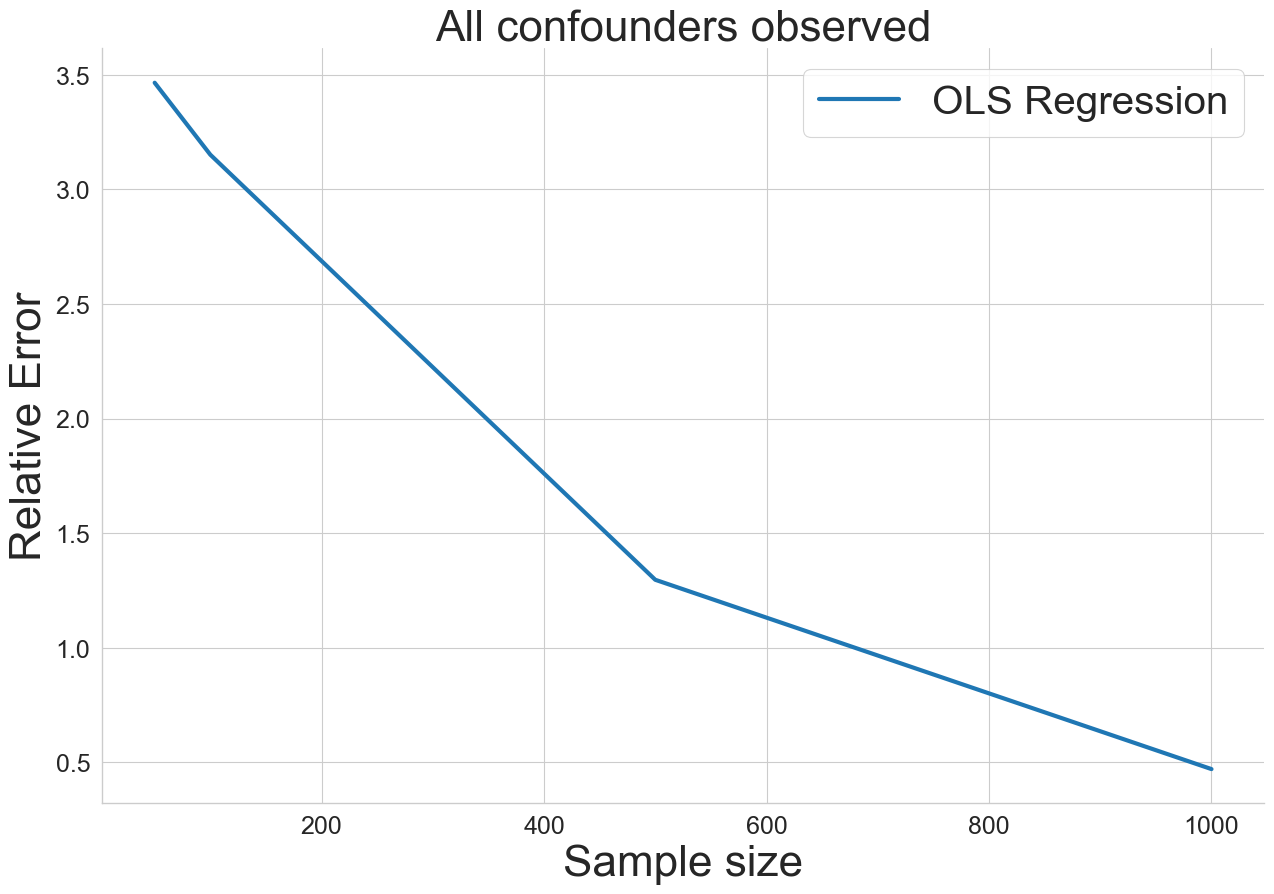

In [16]:
# Plot the relative error as a function of sample size with fully observed confounding
plt.plot(sample_sizes, relative_errors, label="OLS Regression")
plt.xlabel("Sample size")
plt.ylabel("Relative Error")
plt.legend()
plt.title("All confounders observed")
sns.despine()
plt.show()

In [71]:
# Now generate the same experiment, but only observe some of the covariates
biased_estimates, ates = [], []
for dataset in datasets:
    unobserved_confounding_covariates = dataset.covariates[:, 3:6]
    estimate = wn.algorithms.ols.estimate_treatment_effect(
        unobserved_confounding_covariates, dataset.treatments, dataset.outcomes)
    biased_estimates.append(estimate)
    ates.append(dataset.sate)

unobs_relative_errors = [np.abs((estimate.ate - ate) / ate) for (estimate, ate) in zip(biased_estimates, ates)]

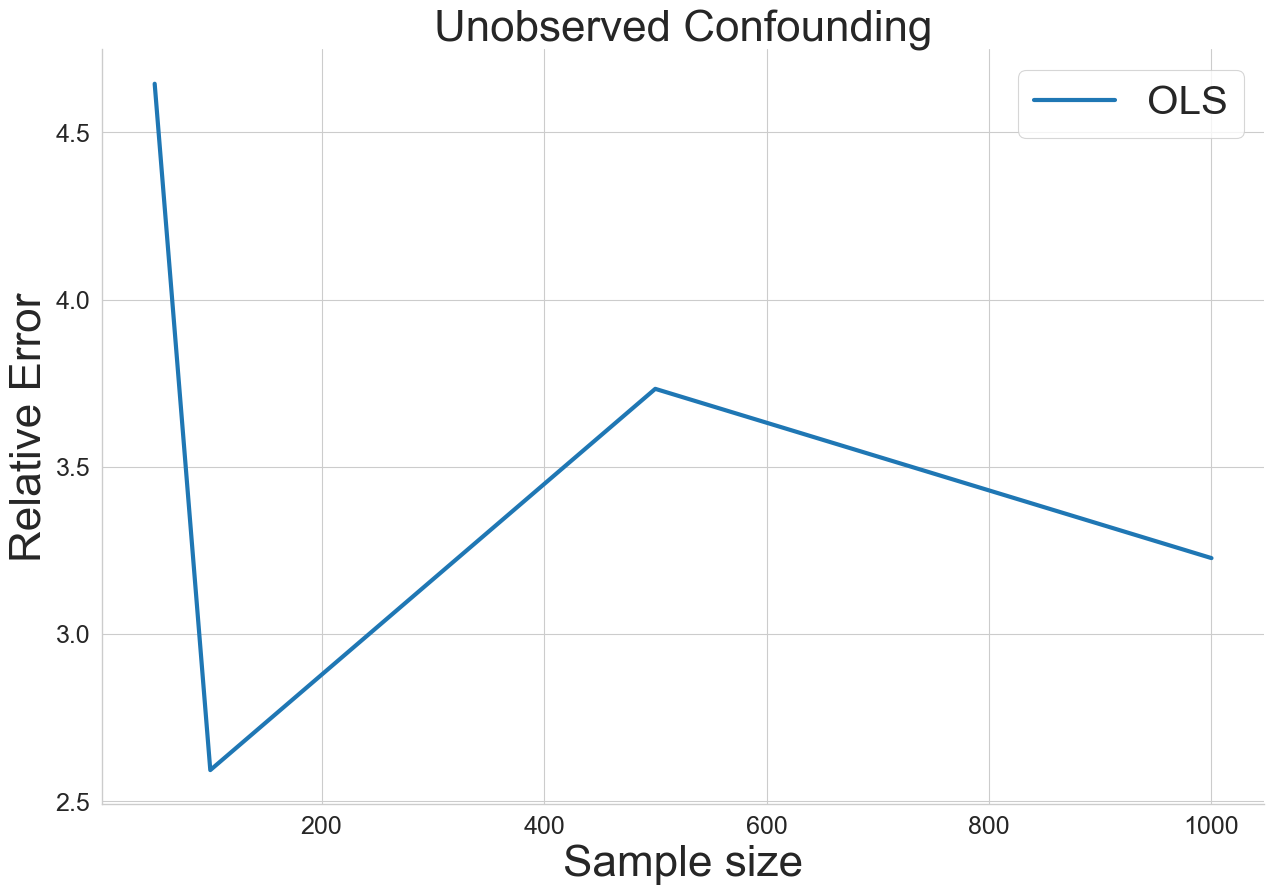

In [72]:
# Plot the relative error as a function of sample size with unobserved confounding
plt.plot(sample_sizes, unobs_relative_errors, label="OLS")
plt.xlabel("Sample size")
plt.ylabel("Relative Error")
plt.title("Unobserved Confounding")
plt.legend()
sns.despine()
plt.show()